In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from datetime import datetime

pd.set_option("display.width", 80) # default value
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("household_power_consumption.txt", sep=";", parse_dates={'ds':['Date', 'Time']}, na_values=['nan', '?'], infer_datetime_format=True,low_memory=False)

In [3]:
df.head(3)

,ds,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000


In [4]:
df.tail(3)

,ds,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075256,2010-11-26 21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.000
2075257,2010-11-26 21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.000
2075258,2010-11-26 21:02:00,0.932,0.000,239.550,3.800,0.000,0.000,0.000


In [5]:
df['Global_active_power']=df['Global_active_power'].apply(lambda x:float(x))
df['Global_reactive_power']=df['Global_reactive_power'].apply(lambda x:float(x))
df['Voltage']=df['Voltage'].apply(lambda x:float(x))
df['Global_intensity']=df['Global_intensity'].apply(lambda x:float(x))
df['Sub_metering_1']=df['Sub_metering_1'].apply(lambda x:float(x))
df['Sub_metering_2']=df['Sub_metering_2'].apply(lambda x:float(x))

In [6]:
df['Global_active_power']=df['Global_active_power'].apply(lambda x: x/60)

In [7]:
df.isnull().sum()

ds                           0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [8]:
df = df.fillna(df.shift(60*24*7))

In [9]:
df.isnull().sum()

ds                       0
Global_active_power      3
Global_reactive_power    3
Voltage                  3
Global_intensity         3
Sub_metering_1           3
Sub_metering_2           3
Sub_metering_3           3
dtype: int64

In [10]:
df = df.fillna(df.shift(60*24*7))

In [11]:
df.isnull().sum()

ds                       0
Global_active_power      2
Global_reactive_power    2
Voltage                  2
Global_intensity         2
Sub_metering_1           2
Sub_metering_2           2
Sub_metering_3           2
dtype: int64

In [12]:
df = df.fillna(df.shift(60*24))

In [13]:
df.isnull().sum()

ds                       0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [14]:
df_resample_H = df.resample('H', on="ds").mean() 
df_resample_H.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
ds,,,,,,,
2006-12-16 17:00:00,0.070,0.229,234.644,18.100,0.000,0.528,16.861
2006-12-16 18:00:00,0.061,0.080,234.580,15.600,0.000,6.717,16.867
2006-12-16 19:00:00,0.057,0.085,233.233,14.503,0.000,1.433,16.683


In [15]:
df_resample_H.reset_index(inplace=True)

In [16]:
df_resample_H.rename(columns={"Global_active_power":"y"}, inplace=True)
df_resample_H = df_resample_H[['ds','y']]

In [17]:
fb_train = df_resample_H[(df_resample_H['ds'] >= '2007-01-01 00:00:00') & (df_resample_H['ds'] < '2010-01-01 00:00:00')]
fb_test = df_resample_H[(df_resample_H['ds'] >= '2010-01-01 00:00:00') & (df_resample_H['ds'] < '2010-10-01 00:00:00')]

In [18]:
print(f"{len(fb_train)} hours of training data \n {len(fb_test)} hours of testing data ")

26304 hours of training data 
 6552 hours of testing data 


In [19]:
round_train = round(len(fb_train)/24)
print(f'days of training data {round_train}')

days of training data 1096


In [20]:
round_days = round(len(fb_test)/24)
print(f'days of testing data {round_days}')

days of testing data 273


In [21]:
m_month = Prophet(seasonality_mode='multiplicative',
              changepoint_prior_scale = 0.001,
              seasonality_prior_scale = 0.01,
              holidays_prior_scale = 0.01,
              changepoint_range = 0.85,
               growth='flat',
               interval_width=0.8)   

In [22]:
m_month.add_seasonality(name='monthly', period=30.5, fourier_order=7 ,mode='multiplicative', prior_scale=0.001)

In [23]:
m_month.fit(fb_train)

16:30:00 - cmdstanpy - INFO - Chain [1] start processing
16:30:01 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
future_month = m_month.make_future_dataframe(periods=round_days, freq='D', include_history=True)

In [25]:
forecast_month = m_month.predict(future_month)

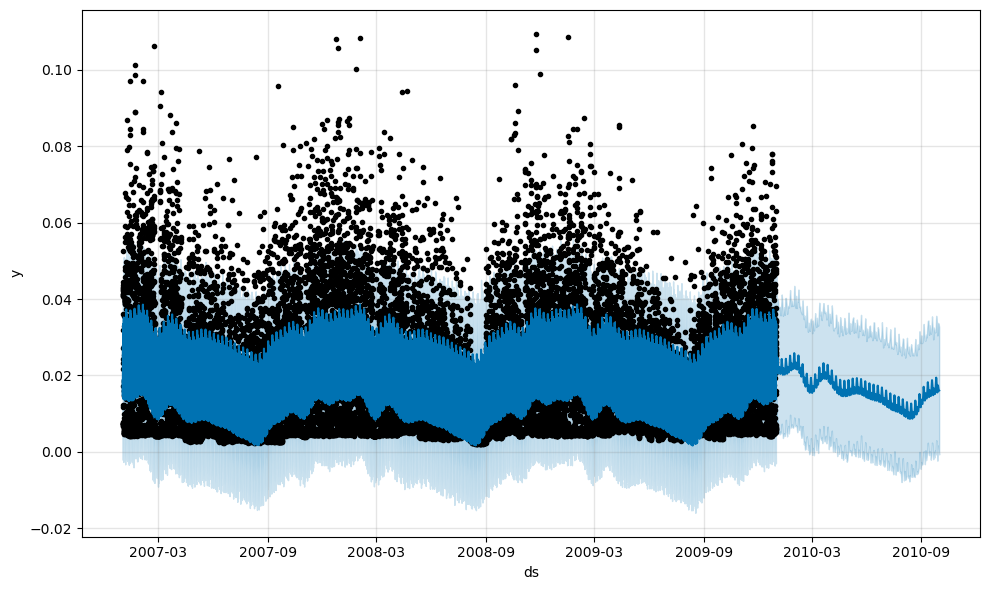

In [26]:
fig1 = m_month.plot(forecast_month)

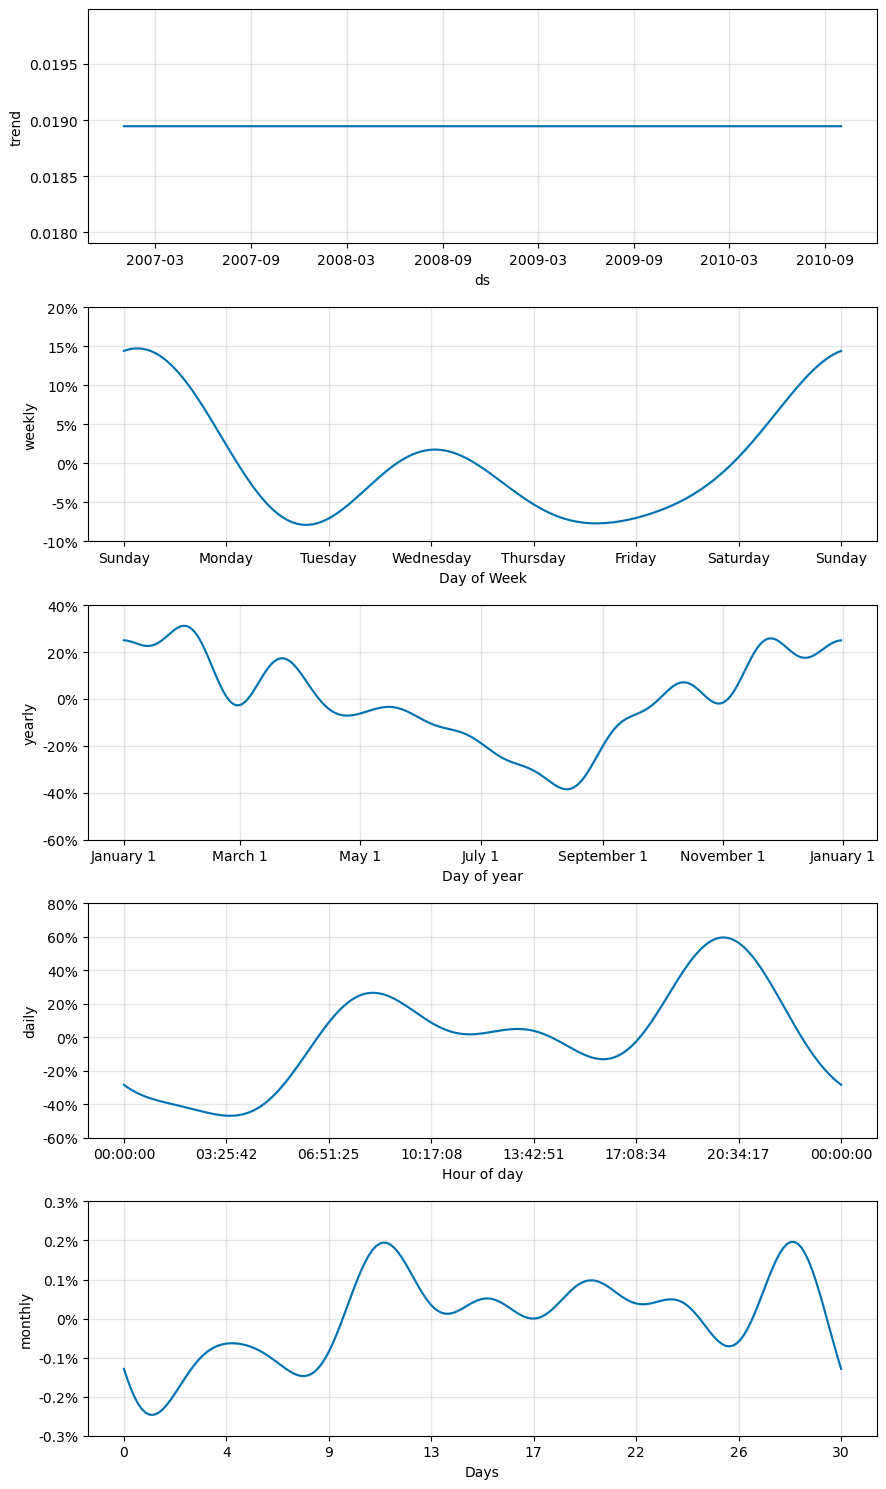

In [27]:
fig2 = m_month.plot_components(forecast_month)

In [28]:
cv_month = cross_validation(m_month,
                         horizon='90 days',
                         period='30 days',
                         initial='540 days',
                         parallel='processes')

In [29]:
cv_p_month = performance_metrics(cv_month)
cv_p_month.head(3)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days 00:00:00,0.000,0.011,0.009,1.045,0.530,0.580,0.909
1,9 days 01:00:00,0.000,0.011,0.009,1.046,0.531,0.580,0.908
2,9 days 02:00:00,0.000,0.011,0.009,1.048,0.532,0.580,0.908


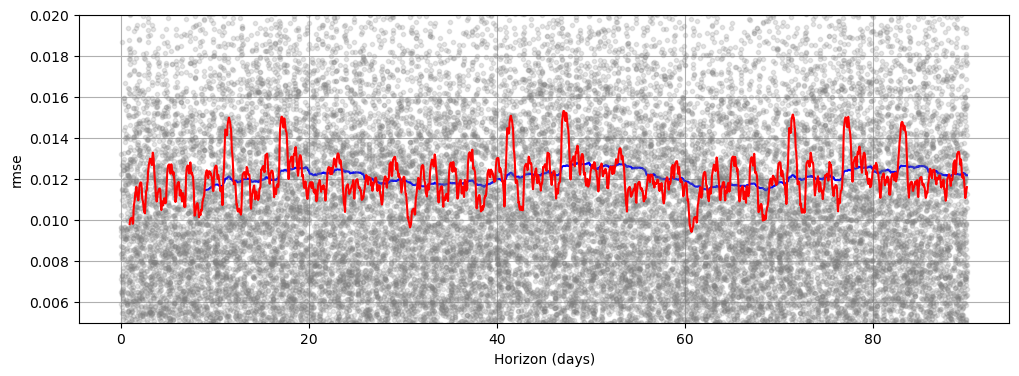

In [30]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)


plot_cross_validation_metric(cv_month,
                             rolling_window=.1,
                             metric='rmse',
                             ax =ax)
                             

plot_cross_validation_metric(cv_month,
                             rolling_window=.01,
                             metric='rmse',
                             color='red',
                             ax = ax)
                             

plt.ylim(0.005, 0.02)
plt.show()

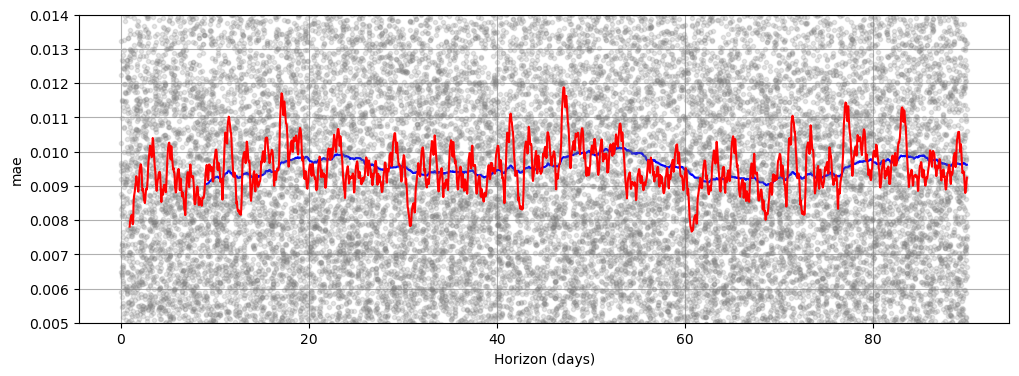

In [31]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)


plot_cross_validation_metric(cv_month,
                             rolling_window=.1,
                             metric='mae',
                             ax =ax)
                             

plot_cross_validation_metric(cv_month,
                             rolling_window=.01,
                             metric='mae',
                             color='red',
                             ax = ax)
                             

plt.ylim(0.005, 0.014)
plt.show()

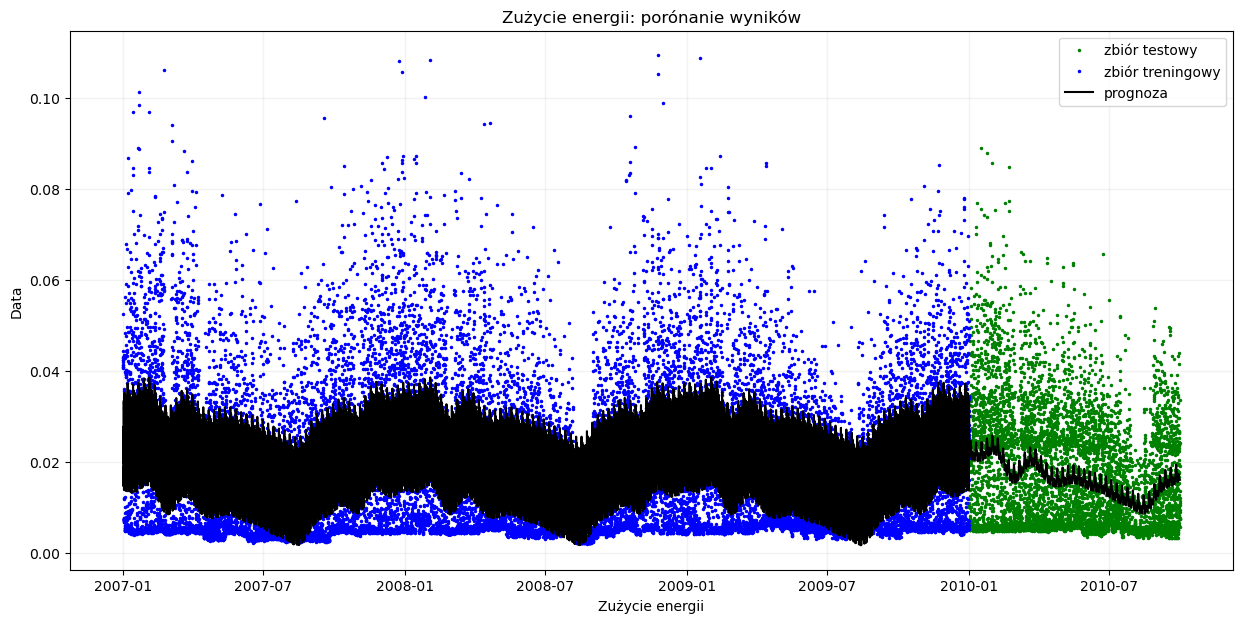

In [32]:
fig = plt.gcf()
fig.set_size_inches(15, 7)
plt.plot(fb_test.ds, fb_test.y, '.',markersize=3, color='green', label = "zbiór testowy")
plt.plot(fb_train.ds, fb_train.y, '.',markersize=3, color='blue', label = "zbiór treningowy")
plt.plot(forecast_month.ds, forecast_month.yhat, color='black', label = "prognoza")
#plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.xlabel('Zużycie energii')
plt.title('Zużycie energii: porónanie wyników')
plt.ylabel('Data')
plt.legend()
plt.show()